In [123]:
# %pip install sentence_transformers
# %pip install fastapi
# %pip install uvicorn
# %pip install scikit-learn
# %pip install joblib
# %pip install wordcloud
# %pip install termcolor

In [124]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.multioutput import MultiOutputClassifier
from sentence_transformers import SentenceTransformer
from sklearn.metrics import classification_report
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import auc as sklearn_auc  # renombramos por seguridad
import numpy as np
import joblib
import os
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from termcolor import colored
import warnings

# Descargar stopwords de nltk si no están disponibles
# nltk.download('stopwords')

# Combinar stopwords de nltk con otras posibles palabras irrelevantes
my_stop_words = {'to-read', 'closed', 'abandoned-books'
'rating-top', 'literature', 'not-interested', 'libricos', 'recommended',
'000-next', 
'001-ladder-top', '002-ladder-short-term', '003-ladder-medium-term', '004-ladder-long-term', 
'005-ladder-maybe-someday', 
'_cristina', '_giorgia', '_natalia', '_nieves', '_pilar', '_sindy', '_víctor', 'chełmińska'
}
stop_words = set(my_stop_words)
stop_words = stop_words.union(set(stopwords.words('english')))
stop_words = stop_words.union(set(stopwords.words('spanish')))
stop_words = stop_words.union(set(stopwords.words('french')))
stop_words = stop_words.union(set(stopwords.words('italian')))

# 1. Cargar el dataset
df = pd.read_csv('../data/processed/books.csv')

# 2. Combinar título y blurb como entrada textual
df['text'] = df['book_title'].fillna('') + '. ' + df['blurb'].fillna('')

# 3. Procesar los tags: convertirlos en listas y filtrar stop-words
def filter_stopwords(tags):
    """
    Filtra las stop-words de una lista de etiquetas.
    """
    return [tag for tag in tags if tag.lower() not in stop_words]

df['tags'] = df['tags'].apply(lambda x: filter_stopwords([t.strip() for t in str(x).split(',')]))

# 4. Binarización multilabel
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(df['tags'])

# 5. Generar embeddings con un modelo multilingüe
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
X_embeddings = model.encode(df['text'].tolist(), show_progress_bar=True)

# Cada texto se convierte en un vector de 384 dimensiones que representa su significado.
print(X_embeddings.shape)

# Muestra los 5 primeros embeddings
print(X_embeddings[:5])

Batches:   0%|          | 0/37 [00:00<?, ?it/s]

(1160, 384)
[[ 0.02750626  0.24533911 -0.28562394 ... -0.07536055 -0.11509603
  -0.052958  ]
 [ 0.13428229  0.19359675 -0.12010901 ...  0.17271587 -0.02152544
   0.20994484]
 [-0.08193501  0.13613778 -0.3626985  ... -0.0060622   0.02430391
  -0.10530125]
 [-0.08946097  0.22455171 -0.21121377 ...  0.11752453  0.10014538
   0.09203939]
 [ 0.03017087  0.09743527 -0.2866786  ...  0.05749123  0.04960755
   0.03592228]]


In [125]:
# 6. Entrenar modelo multilabel
clf = MultiOutputClassifier(LogisticRegression(max_iter=1000))
clf.fit(X_embeddings, Y)

# 7. Guardar modelo y objetos necesarios
joblib.dump(clf, '../model/book_tagging_pipeline.joblib')
joblib.dump(mlb, '../model/book_tagging_pipeline_mlb.joblib')
joblib.dump(model, '../model/book_tagging_pipeline_sentence_bert.joblib')

# ...existing code...

# 8. Función para predecir tags de nuevos libros
def predict_tags(titles, blurbs, threshold=0.3, stop_words=None):
    """
    Predice etiquetas para nuevos libros.
    
    Args:
        titles (list): Lista de títulos de libros.
        blurbs (list): Lista de descripciones de libros.
        threshold (float): Umbral para convertir probabilidades en etiquetas binarias.
        stop_words (set): Conjunto de etiquetas que deben ser filtradas.
        
    Returns:
        list: Lista de listas con las etiquetas predichas (sin las stop words).
    """
    if stop_words is None:
        stop_words = set()  # Si no se proporcionan stop words, usar un conjunto vacío.
    
    texts = [t + '. ' + b for t, b in zip(titles, blurbs)]
    X_test = model.encode(texts)
    
    # Obtener las probabilidades de predicción
    preds_proba = np.array([proba[:, 1] for proba in clf.predict_proba(X_test)]).T
    
    # Aplicar el umbral para convertir probabilidades en etiquetas binarias
    preds = (preds_proba >= threshold).astype(int)
    
    # Invertir la binarización para obtener las etiquetas originales
    tag_lists = mlb.inverse_transform(preds)
    
    # Filtrar las etiquetas que están en stop_words
    filtered_tags = [[tag for tag in tags if tag not in stop_words] for tags in tag_lists]
    return filtered_tags

In [126]:
# Ejemplo de predicción de un libro inventado
new_titles = ["La conspiración del universo"]
new_blurbs = ["Una historia que entrelaza ciencia, fe y filosofía para revelar los secretos de la creación."]
predicted_tags = predict_tags(new_titles, new_blurbs, threshold=0.3, stop_words=my_stop_words)
print(predicted_tags)

[['astronomy', 'philosophy', 'religion', 'science']]


In [127]:
# Ejemplo generación de embeddings para la "Isla del Tesoro" en inglés
new_titles = ["Treasure Island"]
new_blurbs = ["Treasure Island is an adventure novel by Scottish author Robert Louis Stevenson, narrating a tale of buccaneers and buried gold."]
predicted_tags = predict_tags(new_titles, new_blurbs, threshold=0.3, stop_words=my_stop_words)
print(predicted_tags)

[['catholic', 'classics', 'fiction', 'literary-criticism']]


In [128]:
# Ejemplo generación de embeddings para la "Isla del Tesoro" en español
new_titles = ["La isla del tesoro"]
new_blurbs = ["La isla del tesoro es una novela de aventuras del autor escocés Robert Louis Stevenson, que narra una historia de bucaneros y oro enterrado."]
predicted_tags = predict_tags(new_titles, new_blurbs, threshold=0.3, stop_words=my_stop_words)
print(predicted_tags)

[['catholic', 'classics', 'fiction', 'literary-criticism']]


In [129]:
# Ejemplo generación de embeddings para "El Quijote"
new_titles = ["Don Quijote de la Mancha"]
new_blurbs = ["Don Quijote de la Mancha es una novela escrita por el español Miguel de Cervantes Saavedra. Publicada su primera parte con el título de El ingenioso hidalgo don Quijote de la Mancha a comienzos de 1605, es una de las obras más destacadas de la literatura española y la literatura universal."]
predicted_tags = predict_tags(new_titles, new_blurbs, threshold=0.3, stop_words=my_stop_words)
print(predicted_tags)

[['catholic', 'classics', 'spain']]


In [130]:
# Ejemplo de predicción de etiquetas
new_titles = ["La conspiración del universo", "El arte de la guerra", "Cien años de soledad"]
new_blurbs = [
    "Una historia que entrelaza ciencia, fe y filosofía para revelar los secretos de la creación.",
    "Un tratado clásico sobre estrategia militar y liderazgo.",
    "Una obra maestra de la literatura que explora la historia de una familia en un pueblo ficticio."
]
predicted_tags = predict_tags(new_titles, new_blurbs, threshold=0.3, stop_words=my_stop_words)

# Print each item in a new line
for tags in predicted_tags:
    print(tags)

['astronomy', 'philosophy', 'religion', 'science']
['communism', 'history', 'rating-top', 'war']
['children', 'christianity', 'classics', 'fiction', 'memoir']


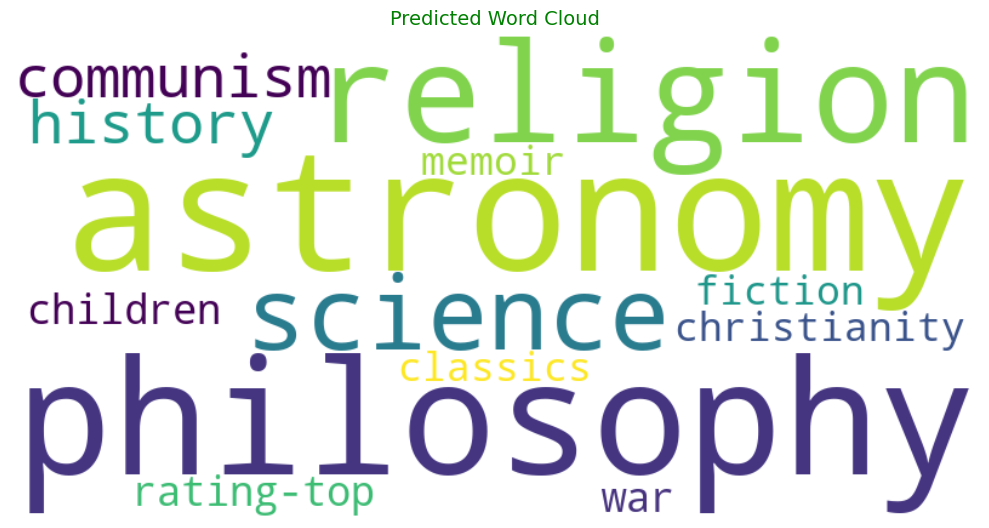

In [131]:
# Contar la frecuencia de las etiquetas
all_tags = [tag for tags in predicted_tags for tag in tags]
tag_counts = Counter(all_tags)

# Generar la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(tag_counts)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Predicted Word Cloud", fontsize=14, color='green')
plt.tight_layout()
plt.savefig('../img/tag_wordcloud.jpg')
plt.show()

In [132]:
# 9. Dividir el dataset en entrenamiento (80%) y evaluación (20%)
df_train, df_test, Y_train, Y_test = train_test_split(df, Y, test_size=0.2, random_state=42)

# Verificar etiquetas en Y_train
valid_labels = np.any(Y_train, axis=0) & np.any(~Y_train, axis=0)  # Etiquetas con al menos un 0 y un 1
Y_train = Y_train[:, valid_labels]  # Filtrar etiquetas problemáticas
Y_test = Y_test[:, valid_labels]    # Ajustar también el conjunto de prueba
mlb.classes_ = mlb.classes_[valid_labels]  # Actualizar las clases del binarizador


# Reentrenar el modelo con el conjunto de entrenamiento
X_train_embeddings = model.encode(df_train['text'].tolist(), show_progress_bar=True)
clf.fit(X_train_embeddings, Y_train)

Batches:   0%|          | 0/29 [00:00<?, ?it/s]

MultiOutputClassifier(estimator=LogisticRegression(max_iter=1000))

In [133]:
# 10. Evaluar el modelo con el conjunto de prueba
X_test_embeddings = model.encode(df_test['text'].tolist(), show_progress_bar=True)
Y_pred = clf.predict(X_test_embeddings)

# Calcular el score y el % de aciertos
print("Classification Report:")
print(classification_report(Y_test, Y_pred, target_names=mlb.classes_))

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Classification Report:
                             precision    recall  f1-score   support

               16th-century       0.00      0.00      0.00         0
               18th-century       0.00      0.00      0.00         0
               19th-century       0.00      0.00      0.00         0
               20th-century       0.00      0.00      0.00         1
         abandonment-in-god       0.00      0.00      0.00         2
                   abortion       0.00      0.00      0.00         0
                 acceptance       0.00      0.00      0.00         1
           action-adventure       0.00      0.00      0.00         0
                adolescence       0.00      0.00      0.00         3
                     adults       0.00      0.00      0.00         0
                     advent       0.00      0.00      0.00         0
                 adventures       0.00      0.00      0.00         8
                     africa       0.00      0.00      0.00         4
      afte

In [134]:
# 11. Comparar predicciones con los tags reales y colorear resultados
def compare_predictions(real_tags, predicted_tags):
    """
    Compara las etiquetas reales con las predichas y las colorea.
    """
    result = []
    for real, predicted in zip(real_tags, predicted_tags):
        comparison = []
        for tag in real:
            if tag in predicted:
                comparison.append(colored(tag, 'green'))  # Acertado
            else:
                comparison.append(colored(tag, 'red'))  # No acertado
        result.append(comparison)
    return result

# Obtener las etiquetas reales y predichas
real_tags = df_test['tags'].tolist()
predicted_tags = predict_tags(df_test['book_title'].tolist(), df_test['blurb'].tolist(), stop_words=stop_words)

# Comparar y mostrar resultados coloreados
colored_results = compare_predictions(real_tags, predicted_tags)
for i, (real, predicted, colored_tags) in enumerate(zip(real_tags, predicted_tags, colored_results)):
    print(f"\nLibro {i + 1}:")
    print(f"Título: {df_test.iloc[i]['book_title']}")
    print(f"Etiquetas reales: {real}")
    print(f"Etiquetas predichas: {predicted}")
    print(f"Comparación coloreada: {', '.join(colored_tags)}")


Libro 1:
Título: Discernment: Reading the Signs of Daily Life
Etiquetas reales: ['catholic', 'spirituality', 'theology']
Etiquetas predichas: ['catholic', 'theology']
Comparación coloreada: catholic, spirituality, theology

Libro 2:
Título: Envoy for Christ: 25 Years as a Catholic Apologist
Etiquetas reales: []
Etiquetas predichas: ['catholic', 'christ', 'conversions', 'devotional', 'prayer']
Comparación coloreada: 

Libro 3:
Título: The Resurrection: Experience Life in the Risen Christ
Etiquetas reales: ['catholic', 'christ', 'lent', 'resurrection', 'testimonies']
Etiquetas predichas: ['catholic', 'spirituality', 'theology']
Comparación coloreada: catholic, christ, lent, resurrection, testimonies

Libro 4:
Título: The Dogma of Purgatory
Etiquetas reales: ['biography', 'catholic', 'church-history', 'dogmas', 'faith', 'illustrated', 'nonfiction', 'purgatory', 'religion', 'saints', 'sobrenatural', 'spirituality', 'suffering', 'testimonies', 'theology', 'visions']
Etiquetas predichas: ['

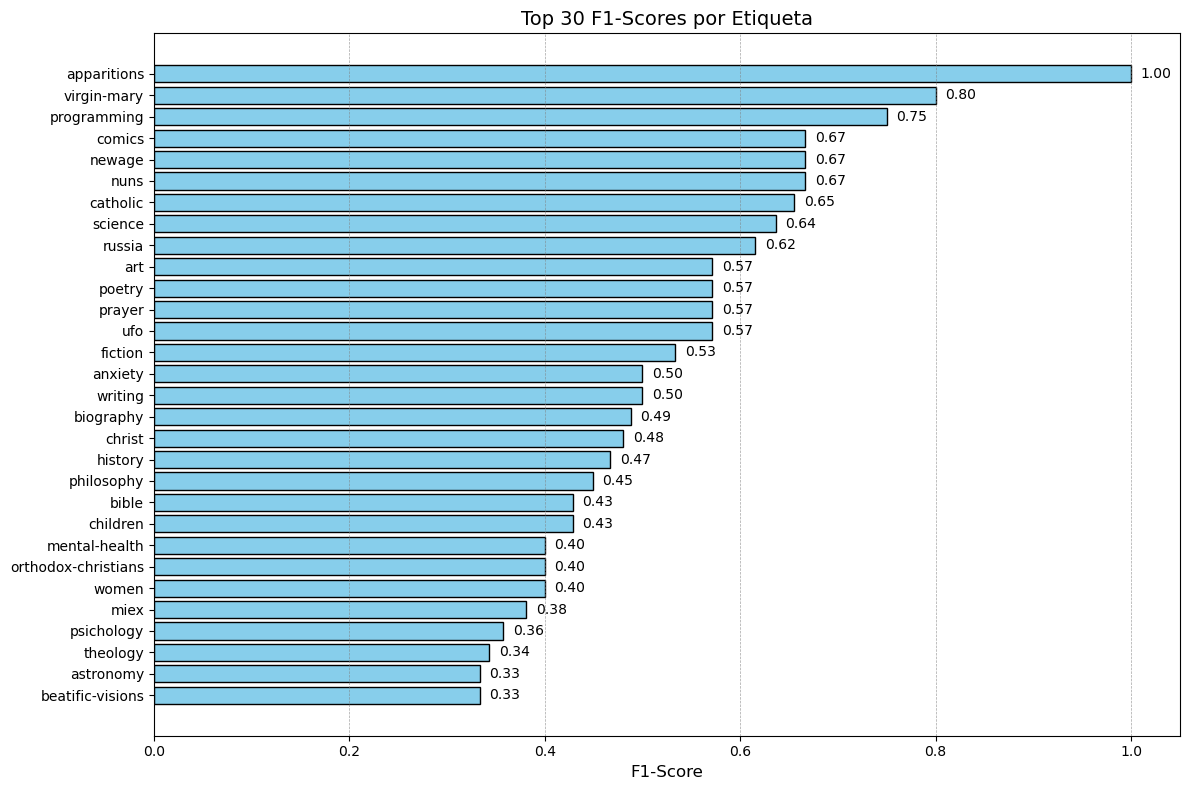

In [135]:
# Ignorar los warnings de métricas indefinidas
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

limit_tags = 30

# Gráfica con las etiquetas con un mejor f1-score
f1_scores = []
for i, tag in enumerate(mlb.classes_):
    report = classification_report(Y_test[:, i], Y_pred[:, i], output_dict=True, zero_division=0)
    # Check if the key '1' exists in the report
    if '1' in report:
        f1 = report['1']['f1-score']
    else:
        f1 = 0.0  # Default value if class '1' is not present
    f1_scores.append((tag, f1))

# Ordenar las etiquetas por F1-score en orden descendente y tomar las 20 primeras
f1_scores = sorted(f1_scores, key=lambda x: x[1], reverse=True)[:limit_tags]
tags, scores = zip(*f1_scores)

# Crear la carpeta si no existe
output_dir = '../img'
os.makedirs(output_dir, exist_ok=True)

# Crear la gráfica
plt.figure(figsize=(12, 8))
bars = plt.barh(tags, scores, color='skyblue', edgecolor='black')

# Añadir divisiones grises claras
plt.grid(axis='x', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

# Añadir etiquetas con los valores al final de cada barra
for bar, score in zip(bars, scores):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2, 
             f'{score:.2f}', va='center', fontsize=10, color='black')

# Configurar etiquetas y título
plt.xlabel('F1-Score', fontsize=12)
plt.title(f'Top {limit_tags} F1-Scores por Etiqueta', fontsize=14)
plt.gca().invert_yaxis()  # Invertir el eje Y para que el mayor F1-score esté arriba

# Guardar la gráfica
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'f1_score_per_tag.jpg'))
plt.show()

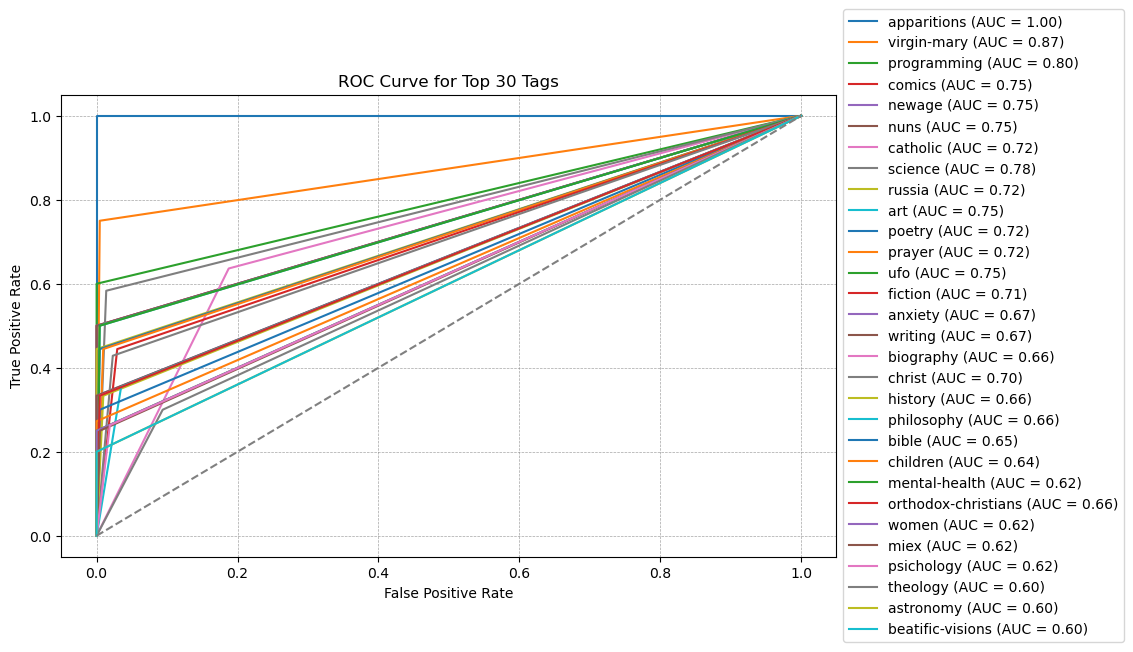

In [136]:
# Mostrar ROC AUC para las 30 etiquetas con mejor F1-score

# Crear la carpeta si no existe
os.makedirs(output_dir, exist_ok=True)

# Crear la gráfica
plt.figure(figsize=(10, 6))
for tag in tags:
    i = np.where(mlb.classes_ == tag)[0][0]
    fpr, tpr, _ = roc_curve(Y_test[:, i], Y_pred[:, i])
    auc = roc_auc_score(Y_test[:, i], Y_pred[:, i])
    plt.plot(fpr, tpr, label=f'{tag} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for Top {limit_tags} Tags')
# Grid with a gray color dash line
plt.grid(linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
# Put the legend on the left side of the graph
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# Guardar la gráfica
plt.savefig(os.path.join(output_dir, 'roc_curve_per_tag.jpg'))
plt.show()

## Curva ROC por etiqueta (Top-N)

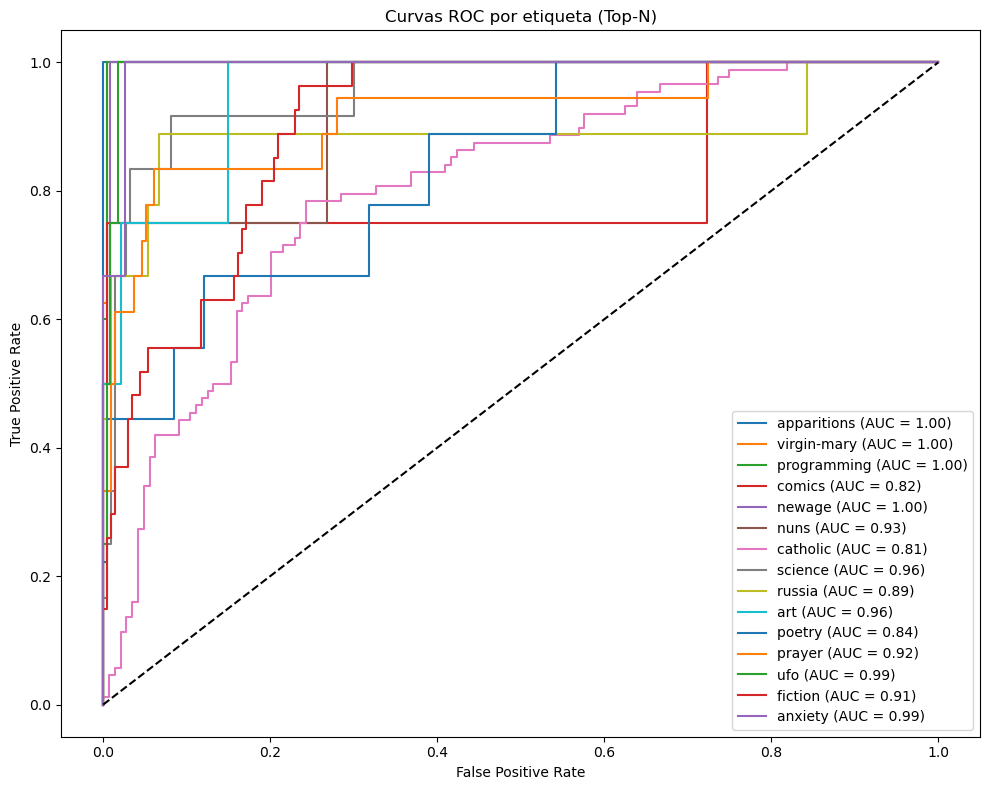

In [141]:
top_n = 15  # Cambia según necesidad
fig, ax = plt.subplots(figsize=(10, 8))

for i in range(top_n):
    tag = tags[i]
    y_true = Y_test[:, mlb.classes_.tolist().index(tag)]
    y_score = clf.predict_proba(X_test_embeddings)[mlb.classes_.tolist().index(tag)][:, 1]
    
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = sklearn_auc(fpr, tpr)
    
    ax.plot(fpr, tpr, label=f'{tag} (AUC = {roc_auc:.2f})')

ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Curvas ROC por etiqueta (Top-N)')
ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'roc_curves_top_tags.jpg'))
plt.show()


## Matriz de Confusión Multilabel simplificada

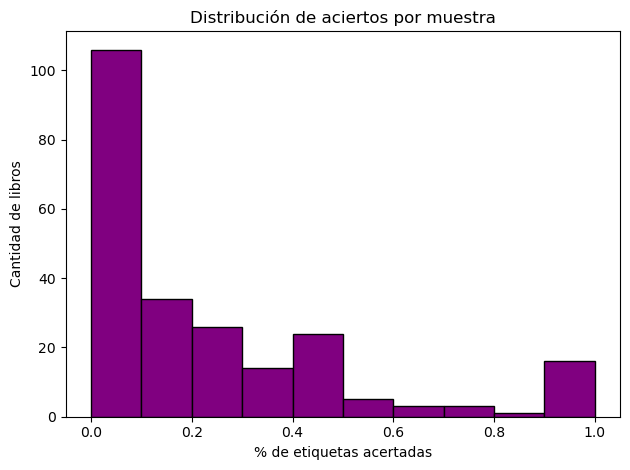

In [142]:
correct_counts = np.sum((Y_pred == Y_test) & (Y_test == 1), axis=1)
total_relevant = np.sum(Y_test, axis=1)
accuracy_per_sample = correct_counts / (total_relevant + 1e-10)

plt.hist(accuracy_per_sample, bins=10, color='purple', edgecolor='black')
plt.title('Distribución de aciertos por muestra')
plt.xlabel('% de etiquetas acertadas')
plt.ylabel('Cantidad de libros')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'accuracy_per_sample_hist.jpg'))
plt.show()


## Precision-Recall por etiqueta (Top-N)

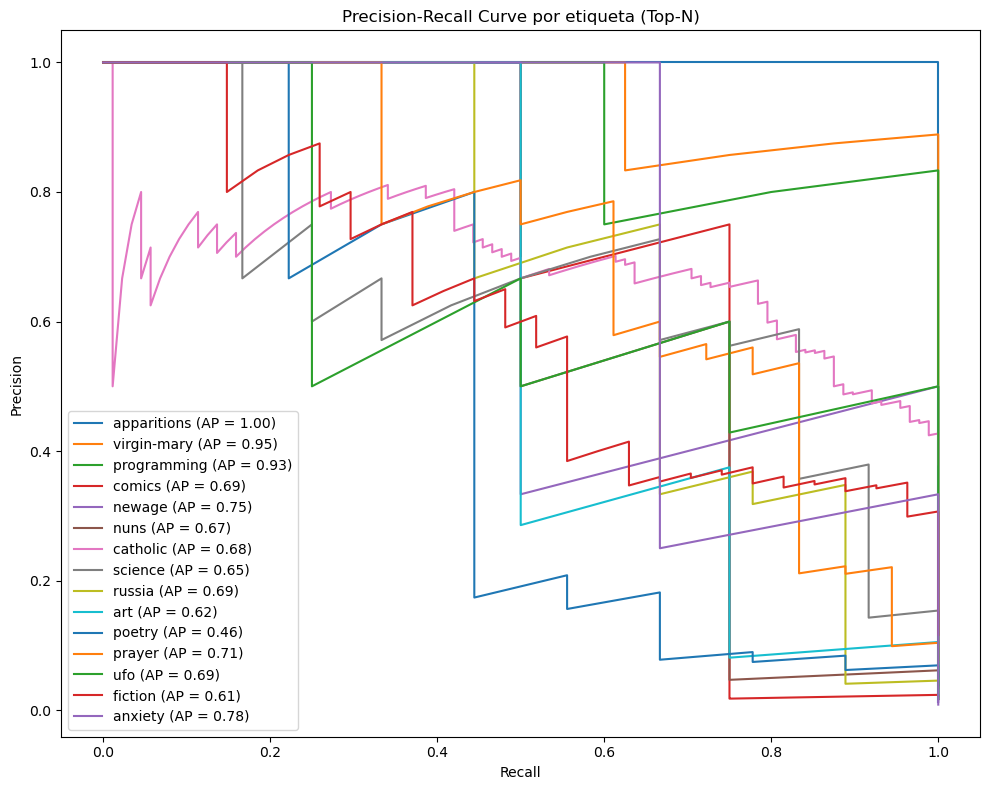

In [143]:
from sklearn.metrics import precision_recall_curve, average_precision_score

fig, ax = plt.subplots(figsize=(10, 8))

for i in range(top_n):
    tag = tags[i]
    y_true = Y_test[:, mlb.classes_.tolist().index(tag)]
    y_score = clf.predict_proba(X_test_embeddings)[mlb.classes_.tolist().index(tag)][:, 1]
    
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    avg_precision = average_precision_score(y_true, y_score)
    
    ax.plot(recall, precision, label=f'{tag} (AP = {avg_precision:.2f})')

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curve por etiqueta (Top-N)')
ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'precision_recall_curves.jpg'))
plt.show()


## Cobertura de etiquetas reales vs predichas

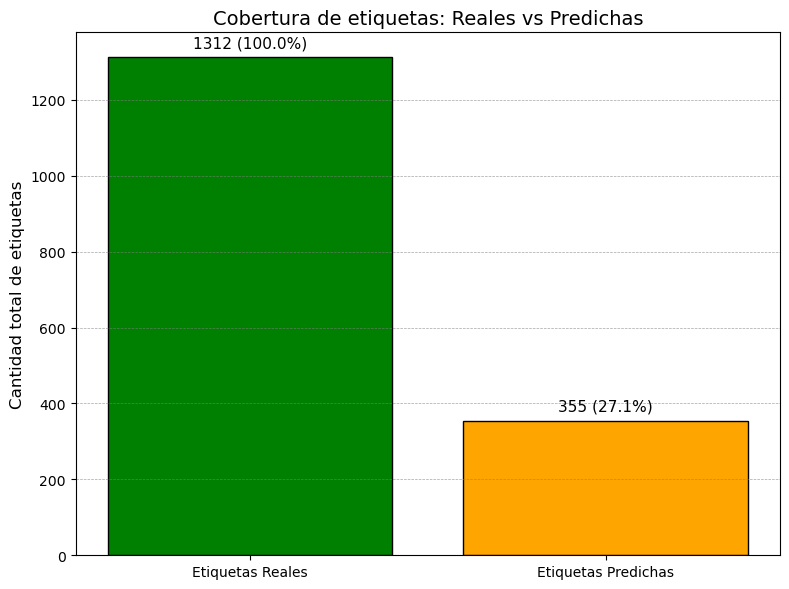

In [ ]:
# Gráfico comparando cobertura de etiquetas reales vs predichas
true_tag_count = np.sum(Y_test)
pred_tag_count = np.sum(Y_pred)

labels = ['Etiquetas Reales', 'Etiquetas Predichas']
counts = [true_tag_count, pred_tag_count]

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, counts, color=['green', 'orange'], edgecolor='black')

# Añadir líneas de grid horizontales
plt.grid(axis='y', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

# Etiquetas con porcentaje sobre cada barra
total = max(counts)
for bar, count in zip(bars, counts):
    percent = (count / total) * 100
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + total * 0.02,
             f'{count:.0f} ({percent:.1f}%)', ha='center', fontsize=11)

plt.title('Cobertura de etiquetas: Reales vs Predichas', fontsize=14)
plt.ylabel('Cantidad total de etiquetas', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'label_coverage_comparison.jpg'))
plt.show()

### 📊 Cobertura de Etiquetas: ¿Cuánto predijo bien el modelo?

- En el conjunto de prueba (20% de los libros), había un total de **1312 etiquetas reales**.
- El modelo logró predecir correctamente **355 etiquetas**, lo que representa un **27.1%** del total.

---

### ✅ ¿Qué significa esto?

- El modelo **está captando parte del significado de los textos**, pero **todavía deja muchas etiquetas sin predecir**.
- Esto **no es necesariamente malo** en multilabel: es común que un modelo sea **conservador** para evitar errores.
- **Mejorando el umbral**, los datos o el modelo podríamos aumentar esta cobertura.

---

### 🧠 ¿Y ahora qué?

- Analizar etiquetas frecuentes que nunca se predicen (¿quizás faltan ejemplos de ellas?).
- Evaluar si el **umbral de 0.3** es demasiado alto o bajo para este caso.
- Podríamos usar un modelo más complejo, más datos, o técnicas como **data augmentation** o **re-balanceo de clases**.